# Code for Statistical Power of Classical Associative Tests in _Asymmetrical reliability of the Alda Score favours a dichotomous representation of lithium responsiveness_

__Abraham Nunes (nunes@dal.ca), Thomas Trappenberg, and Martin Alda__

_Dalhousie University, Halifax, Nova Scotia, Canada_

In [0]:
import time
import numpy as np 
import pandas as pd
import scipy.stats as ss
import matplotlib 
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.size'] = 12

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as skm
from scipy.special import binom as C
from scipy.special import poch, gamma
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats import power as smp
import statsmodels.api as sm


# Data Generating Functions

In [0]:
def reflection(x, l=0, u=10):
    return np.maximum(np.minimum(x, np.maximum(2*u-x, l)), np.minimum(2*l-x, u))

def sigmoid(x, beta=0.75, c=5):
    return 1/(1 + np.exp(-beta*x + c))

def asymmetric_data(n=100, sigma=1,l=0, u=10, rng=np.random.RandomState()):
    x = np.linspace(l, u, n)[:,None]
    U = rng.uniform(-sigma, sigma, size=x.shape)
    return np.hstack((x, reflection(x + sigmoid(x)*U, l, u)))

def symmetric_data(n=100, sigma=1, l=0, u=10, rng=np.random.RandomState()):
    x = np.linspace(l, u, n)[:,None]
    U = rng.uniform(-sigma, sigma, size=x.shape)
    y = MinMaxScaler(feature_range=(l, u)).fit_transform(x + U)
    return np.hstack((x, y))

def noisy_data(n=100, sigma=1, pnoise=0.5, l=0, u=10, symmetric=True, rng=np.random.RandomState()):
    n_data = int((1-pnoise)*n)
    n_noise = n-n_data
    if symmetric:
        X = symmetric_data(n_data,sigma,l,u,rng)
    else: 
        X = asymmetric_data(n_data,sigma,l,u,rng)
    return np.vstack((X, rng.uniform(l, u, size=(n_noise, 2))))

def discretize_data(X, threshold=5):
    return np.less(X, threshold).astype(np.int)
    
def oddsratio(X):
    return (X[0,0]*X[1,1])/(X[0,1]*X[1,0])

def confusion_matrix(X):
    return skm.confusion_matrix(X[:,0], X[:,1])

def fisher_stats(X, threshold=5):
    cm = confusion_matrix(discretize_data(X, threshold))
    n = cm.sum(0)[1]; nsucc=cm.sum(1)[1]; ntot=cm.sum();
    odds_ratio = oddsratio(cm)
    return n, nsucc, ntot, odds_ratio

# Fisher Distributions and Exact Test

In [0]:
class FisherHypergeometricDistribution(object):
    def __init__(self, X=None, n=None, nsucc=None, ntot=None, odds_ratio=None):
        if X is not None:
            cm = confusion_matrix(X)
            n = cm.sum(0)[1]; nsucc=cm.sum(1)[1]; ntot=cm.sum();
            odds_ratio = oddsratio(cm)

        self.n = n
        self.ntot = ntot 
        self.nsucc = nsucc
        self.nfail = self.ntot - self.nsucc
        self.odds_ratio = odds_ratio
        self.xmin = np.maximum(self.n-self.nfail, 0)
        self.xmax = np.maximum(self.n, self.nsucc)

    
        self.domain = np.array([x for x in range(self.xmin, self.xmax + 1)])
        self.prob = np.array([C(self.nsucc, x)*C(self.nfail, self.n-x)*(self.odds_ratio**x) for x in self.domain])
        self.Z = np.sum(self.prob)
        self.prob = self.prob/self.Z
        self.cumprob = np.cumsum(self.prob)
        self.tailprob = 1 - self.cumprob

    def compute_normalization_constant(self):
        return np.sum([C(self.nsucc, y)*C(self.nfail, self.n-y)*(self.odds_ratio**y) for y in range(self.xmin, self.xmax+1)])
    
    def pmf(self, x):
        return self.prob[np.equal(self.domain, x)]
    
    def sf(self, x):
        if x + 1 < self.domain[-1]:
            tailprob = self.tailprob[np.equal(self.domain, x)]
        elif x < self.xmin: 
            tailprob = 1 
        else:
            tailprob = 0
        return tailprob
    
    def cdf(self, x):
        if x < self.xmin: 
            cprob = 0
        else: 
            cprob = self.cumprob[np.equal(self.domain, x)]
        return cprob

    def ppf(self, p):
        return self.domain[np.less_equal(p - self.cumprob, 0)][0]

class FisherExactTest(object):
    def __init__(self, X, null_odds_ratio=1, alternative="two.sided", alpha=0.05):
        self.X = X
        self.ntot = X.sum()
        self.nsucc = X.sum(1)[1]
        self.nfail = self.ntot - self.nsucc
        self.n = X.sum(0)[1]
        self.sample_odds_ratio = (X[0,0]*X[1,1])/(X[0,1]*X[1,0])
        self.null_odds_ratio = 1
        self.P_null = FisherHypergeometricDistribution(n=self.n, 
                                                       nsucc=self.nsucc, 
                                                       ntot=self.ntot,
                                                       odds_ratio=self.null_odds_ratio)
        self.P_alt = FisherHypergeometricDistribution(n=self.n, 
                                                      nsucc=self.nsucc, 
                                                      ntot=self.ntot, 
                                                      odds_ratio=self.sample_odds_ratio)
        self.alternative = alternative
    
    def power(self, alpha=0.05):
        if self.alternative == "two.sided":
            if self.sample_odds_ratio < self.null_odds_ratio:
                ql = self.P_null.ppf(alpha/2) - 1
                power = self.P_alt.cdf(ql)
            else: 
                qu = self.P_null.ppf(1-alpha/2) - 1
                power = self.P_alt.sf(qu)
            
        elif self.alternative == "greater":
            qu = self.P_null.ppf(1-alpha) - 1
            power = self.P_alt.sf(qu)
        else: 
            ql = self.P_null.ppf(alpha) -1 
            power = self.P_alt.cdf(ql)
        return power

# Statistical Functions for Experiments

In [0]:
def fisher_transform(rho):
    return np.log((1+rho)/(1-rho))/2

def pearson_rho(X):
    return ss.pearsonr(X[:,0], X[:,1])

def corr_power(rho, n, null_rho=0, alpha=0.05):
    zeta = np.abs(fisher_transform(rho)-fisher_transform(null_rho))
    Zalpha = ss.norm().ppf(1-alpha/2)
    return 1 - ss.norm().sf(zeta*np.sqrt(n-3) - Zalpha)

def rhotest(n,s,w,sym):
    return corr_power(pearson_rho(noisy_data(n, sigma=s, pnoise=w, symmetric=sym))[0], n)

ftest = lambda n,s,w,sym,tau: FisherExactTest(confusion_matrix(discretize_data(noisy_data(n=n, sigma=s, pnoise=w, symmetric=sym), threshold=tau))).power()[0]

# Run experiment

In [0]:
n = 100
sigmas, noise, thresholds, samples = np.meshgrid(np.arange(1, 21), 
                                                 [0.3, 0.5, 0.7], 
                                                 [3, 5], 
                                                 np.arange(100))

## Fisher's exact test power

In [0]:
results = pd.DataFrame({
    "SD": sigmas.flatten(), 
    "Noise": noise.flatten(),
    "Dichotomization Threshold":thresholds.flatten(), 
    "Sample": samples.flatten(), 
    "Symmetric": [True]*samples.size})
results_asym = results.copy() 
results_asym['Symmetric'] = False 
results = pd.concat([results, results_asym])
del(results_asym)
par = results[["SD", "Noise", "Symmetric","Dichotomization Threshold"]].values

In [0]:
results['Power'] = [ftest(n,s,w,sym,tau) for s,w,sym,tau in par]
results['Test'] = "Fisher Exact"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


## Pearson Correlation Power

In [0]:
results_pearson = results.loc[results["Dichotomization Threshold"] == 3].copy() 
par_pearson = results_pearson[["SD", "Noise", "Symmetric"]].values
results_pearson['Test'] = "Pearson Correlation"
results_pearson["Dichotomization Threshold"] = "No threshold"
results_pearson["Power"] = [rhotest(n, s, w, sym) for s,w,sym in par_pearson]

## Merge Test Results

In [0]:
results_all = pd.concat([results, results_pearson])
results_all.loc[results_all["Dichotomization Threshold"] == 3, "Dichotomization Threshold"] = "Tail Split"
results_all.loc[results_all["Dichotomization Threshold"] == 5, "Dichotomization Threshold"] = "Median Split" 
results_all.loc[results_all["Dichotomization Threshold"] == "No threshold", "Dichotomization Threshold"] = "No Threshold (Continuous)" 
results_all.loc[results_all["Symmetric"] == False, "Symmetric"] = "Asymmetric"
results_all.loc[results_all["Symmetric"] == True, "Symmetric"] = "Symmetric" 

In [0]:
results_all.columns = ["Diagonal Spread", "Overall Noise", "Dichotomization", "Sample", "Agreement", "Statistical Power", "Test"]

## Plot Results

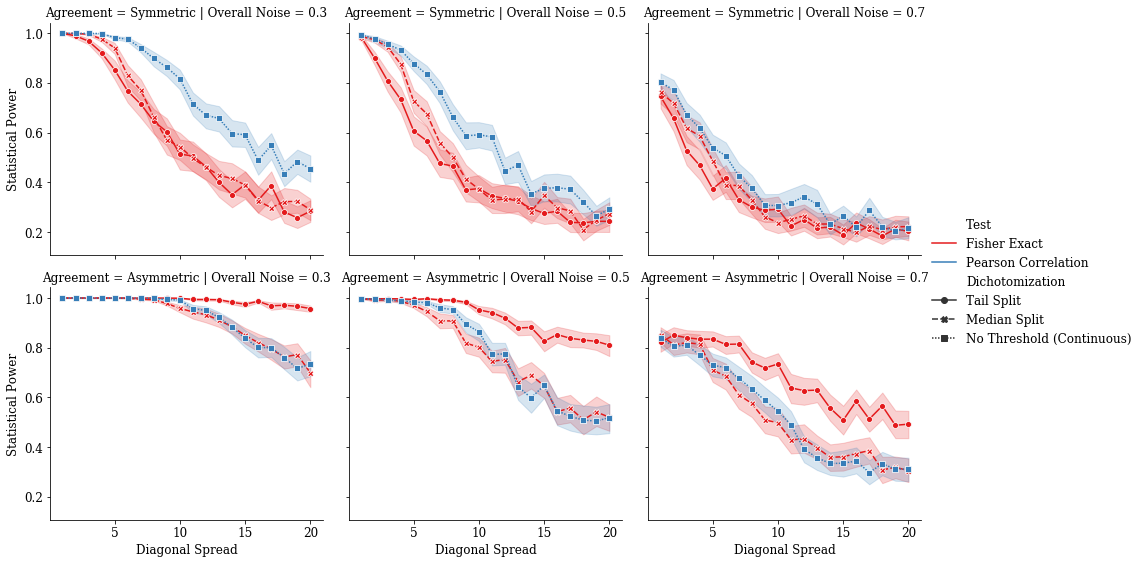

In [0]:
ax = sns.relplot(x="Diagonal Spread", 
                 y="Statistical Power", 
                 hue="Test", 
                 style="Dichotomization",
                 col="Overall Noise",
                 row="Agreement",
                 palette="Set1",
                 markers=True,
                 height=4, 
                 aspect=1.1,
                 kind="line",
                 data=results_all)
plt.savefig('testresults.pdf', bbox_inches="tight")